# Synthetic Matching

A minimal, step-by-step walkthrough to perform image matching using our 'Stretcher' method with a synthetic deformation.

Steps:
1) Pick parameters and the image to be synthetically deformed and matched
2) Display images
3) Extract keypoints
4) Match without Stretcher for comparison
5) Apply Stretcher to adapt descriptors
6) Match with Stretcher


In [1]:
from DeDoDe.utils import get_best_device
import PIL.Image as Image
from util.matching import draw_matches_with_scores
from src.notebook_utils import extract_superpoint_keypoints, matching, stretch_descriptions, stretched_matching, create_deformed_medical_image_pair, evaluate_matches

### 1) Pick parameters
Minimal parameters for reproducibility. Adjust paths and numbers as needed.


In [2]:
device = get_best_device()
print(f"Using device: {device}")

# Image paths
base_image_path = 'data/medical_deformed/pig_liver_to_elongate.png'
deformed_image_path = 'data/medical_deformed/pig_liver_to_elongate_deformed.png'

# Stretcher model
model_path = "models/spstretcher_new.pth"

# Matcher selection: 'dsm' or 'lightglue'
matcher = 'lightglue'

# Number of keypoints to be extracted
num_keypoints = 10000

Using device: mps


### 2) Display images
Loading and quick visual check of the two images used for matching.


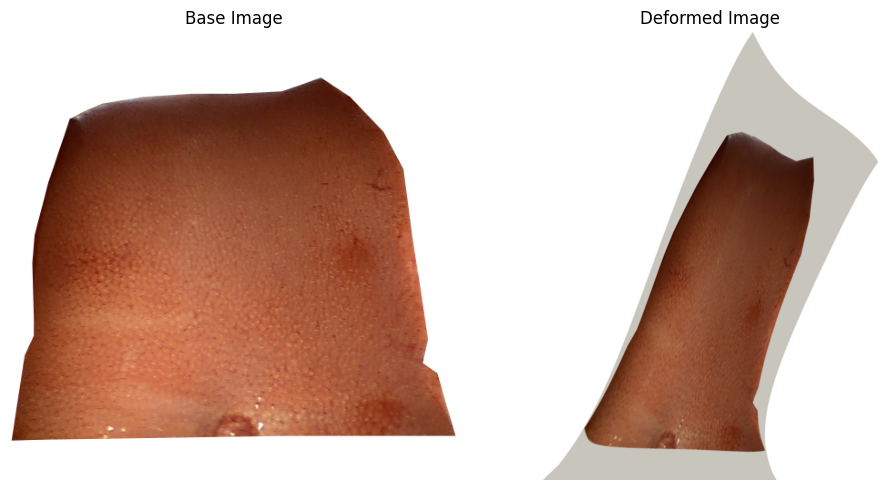

In [3]:
base_image, deformed_image, deformation_info = create_deformed_medical_image_pair(base_image_path, deformed_image_path, 8e6, 1e6 )

### 3) Extract keypoints
Use SuperPoint to detect keypoints and compute descriptors; measure the extraction time.


In [4]:
base_features, deformed_features = extract_superpoint_keypoints(base_image_path, deformed_image_path, device, num_keypoints)

Description time: 1.138s


### 4) Normal Matching (for comparison)
Run either DSM or LightGlue depending on `matcher`.


Baseline LightGlue matching time: 5.637s
Baseline Accuracy: 0.9795918367346939 (144 / 147)


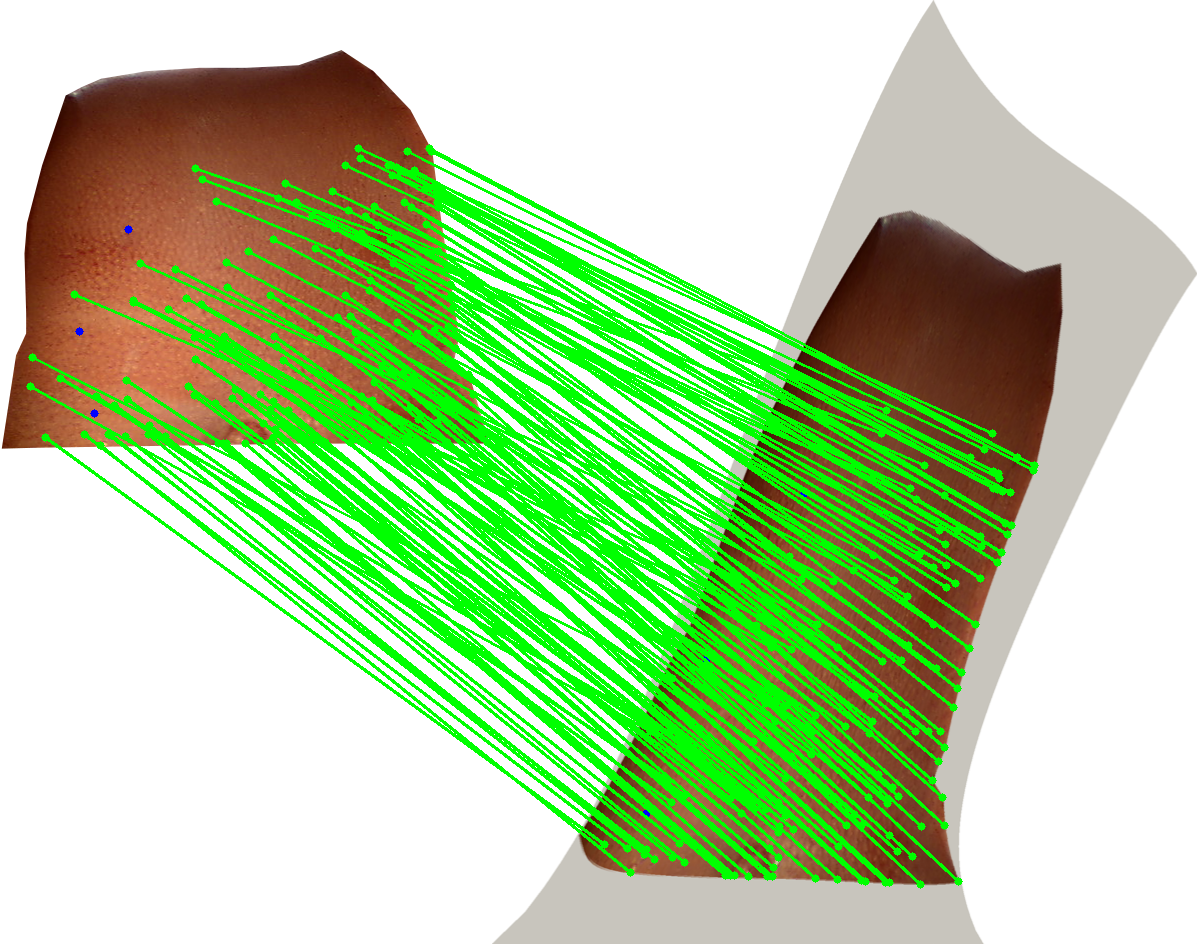

In [5]:
# Step 4: baseline matching via src function
matches_image, base_matches, deformed_matches = matching(
    matcher,
    base_features, deformed_features,
    base_image, deformed_image,
    device,
    image=False
)

distances = evaluate_matches(base_matches, deformed_matches, deformation_info)

baseline_matches_image = Image.fromarray(draw_matches_with_scores(base_image, base_matches.cpu(), deformed_image, deformed_matches.cpu(), distances, 5, lines=True))
baseline_matches_image

### 5) Stretch descriptors
Apply the learned stretcher to adapt base descriptors under strain; this produces a tensor of stretched descriptors.


In [6]:
stretched_descriptions = stretch_descriptions(base_features, device, model_path)

Stretching time: 1.804s


### 6) Match using the Stretched Descriptions
Run either DSM or LightGlue adjusted to work with stretched descriptions.


Stretched LightGlue matching time: 558.590s
Baseline Accuracy: 0.7134146341463414 (234 / 328)


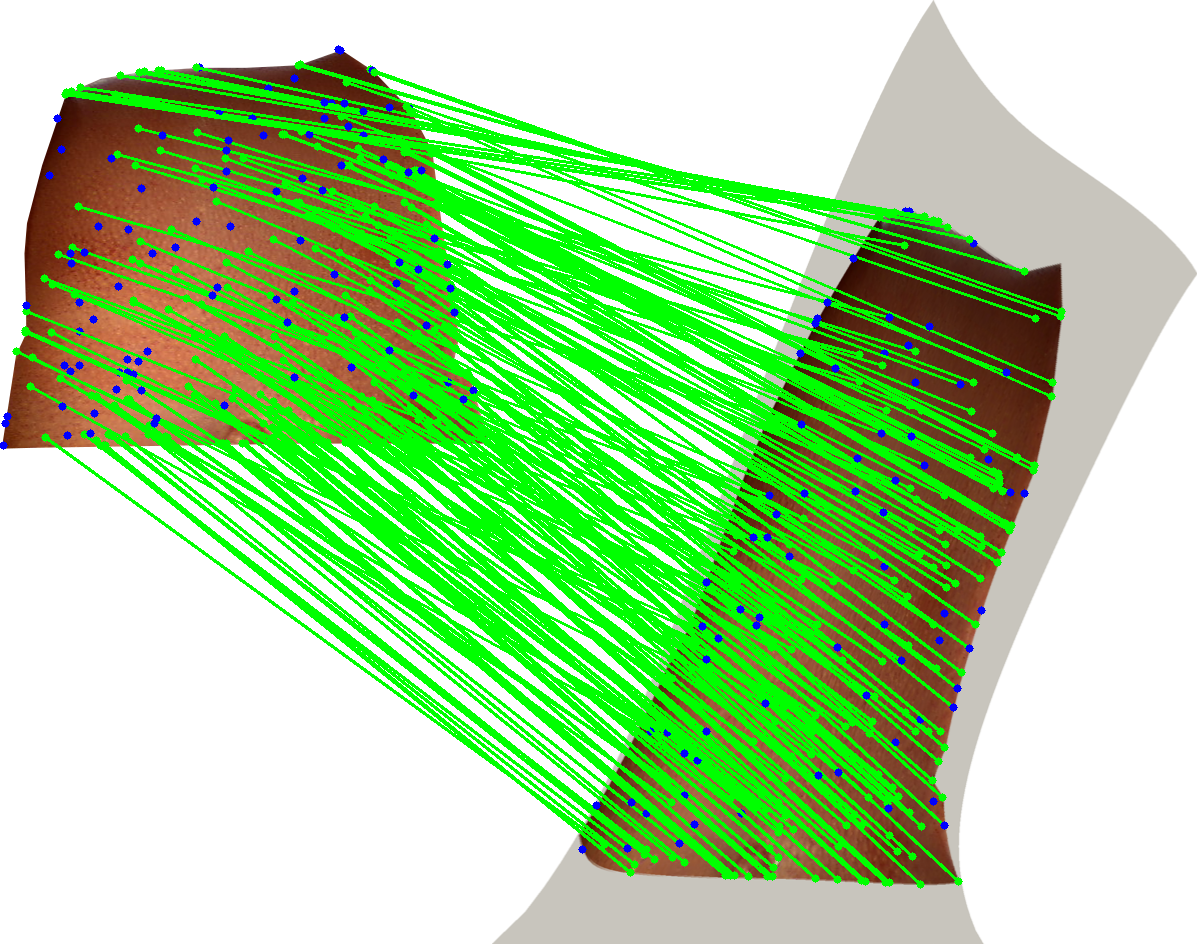

In [7]:
stretched_matches_image, stretched_base_matches, stretched_deformed_matches = stretched_matching(
    matcher,
    base_features, deformed_features,
    stretched_descriptions,
    base_image, deformed_image,
    device,
    image=False,
)

distances = evaluate_matches(stretched_base_matches, stretched_deformed_matches, deformation_info)

stretched_matches_image = Image.fromarray(draw_matches_with_scores(base_image, stretched_base_matches.cpu(), deformed_image, stretched_deformed_matches.cpu(), distances, 5, lines=True))
stretched_matches_image